In [ ]:
###업데이트 할 파일

###Macro Senti
###CLI
###Transfer
###NFCI
###각종 팩터 인덱스

테이블의 열의 개수: 77


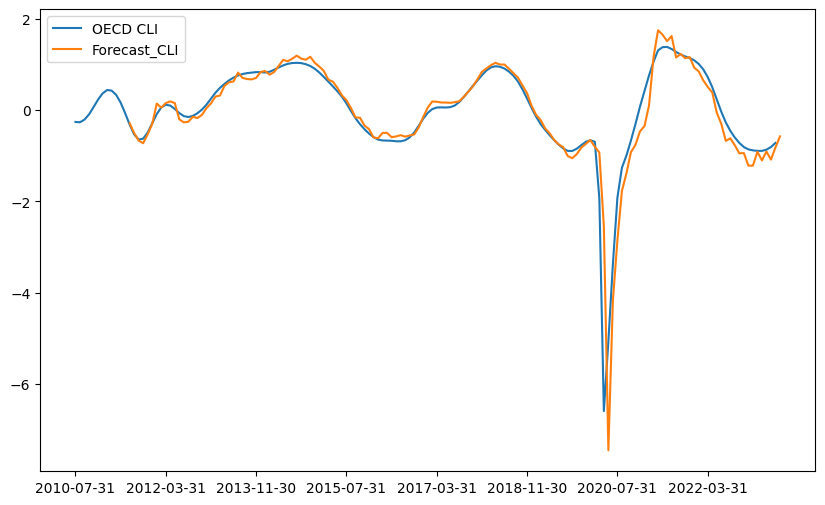

In [ ]:
########CLI 모델링

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 파일 경로 설정
file_path = '/content/drive/MyDrive/Macro Senti.csv'

# CSV 파일 로드
df = pd.read_csv(file_path)

# 0번째 열을 인덱스로 설정
df = df.set_index(df.columns[0])

# 컬럼 이름 변경
df.index.name = '날짜'

# "Unnamed"으로 시작하는 열들 삭제
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]

num_columns = len(df.columns)
print("테이블의 열의 개수:", num_columns)

# 1번째 행 삭제
df = df.drop(df.index[0])

# '#N/A', '#VALUE' 값을 NaN으로 대체
df.replace(['#N/A N/A', '#VALUE!'], np.nan, inplace=True)

# 모든 열의 데이터를 float64로 변환
df = df.astype(float)

# NaN이나 NA 값이 있는 행 제거
df = df.dropna()

# 각 열을 z-score로 표준화
scaler = StandardScaler()
df_zscore = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

# rolling z-score 계산
window_size = 12

# 각 열에 대해 롤링 z-score 계산 함수 정의
def calculate_rolling_zscore(column):
    rolling_mean = column.rolling(window=window_size).mean()
    rolling_std = column.rolling(window=window_size).std()
    z_score = (column - rolling_mean) / rolling_std
    return z_score


############################Covid-19 이전 데이터 관계기반 전처리################################

# 상관관계 양수로 전환
correlations = df_zscore.iloc[:116].corrwith(df_zscore.iloc[:116, 0])

# 상관관계가 음수인 변수의 데이터에만 -1을 곱하는 코드
negative_variables = correlations[correlations < 0].index
df_zscore.loc[:, negative_variables] *= -1

# 상관관계 전체 양수인지 체크
correlations = df_zscore.iloc[:116].corrwith(df_zscore.iloc[:116, 0])

Credit = pd.read_csv('/content/drive/MyDrive/Credit.csv')
FX = pd.read_csv('/content/drive/MyDrive/FX.csv')
Financial_Condition = pd.read_csv('/content/drive/MyDrive/Financial Condition.csv')
Hard_Data = pd.read_csv('/content/drive/MyDrive/Hard Data.csv')
Soft_Data = pd.read_csv('/content/drive/MyDrive/Soft Data.csv')
LS_Spread = pd.read_csv('/content/drive/MyDrive/LS Spread.csv')
Vol = pd.read_csv('/content/drive/MyDrive/Vol.csv')

# 각 데이터프레임의 컬럼명을 저장할 리스트 생성
Credit_Col = Credit.columns.tolist()
FX_Col = FX.columns.tolist()
Financial_Condition_Col = Financial_Condition.columns.tolist()
Hard_Data_Col = Hard_Data.columns.tolist()
Soft_Data_Col = Soft_Data.columns.tolist()
LS_Spread_Col = LS_Spread.columns.tolist()
Vol_Col = Vol.columns.tolist()

# 새로운 데이터프레임 Input_index 생성
input_index = pd.DataFrame(index=df_zscore.index)

# 가로행 평균으로 된 인덱스 추가
input_index['Credit_index'] = df_zscore[Credit_Col].mean(axis=1)
input_index['FX_index'] = df_zscore[FX_Col].mean(axis=1)
input_index['Financial_Condition_index'] = df_zscore[Financial_Condition_Col].mean(axis=1)
input_index['Hard_Data_index'] = df_zscore[Hard_Data_Col].mean(axis=1)
input_index['Soft_Data_index'] = df_zscore[Soft_Data_Col].mean(axis=1)
input_index['LS_Spread_index'] = df_zscore[LS_Spread_Col].mean(axis=1)
input_index['Vol_index'] = df_zscore[Vol_Col].mean(axis=1)

# 맨 앞 열에 df_zscore의 0번째 열 추가
column_name = df_zscore.columns[0]
input_index.insert(0, column_name, df_zscore.iloc[:, 0])

##### input_index에 CLI 레깅값 넣기#####
input_index['CLI_lag'] = input_index['OECD CLI'].shift(1)
input_index.dropna(inplace=True)

##### 윈도우 늘려가면서 coef, str 구하기
import pandas as pd
import statsmodels.api as sm

# 독립변수와 종속변수 선택
X = input_index.iloc[:, 1:9]  # 1번부터 8번 열까지 독립변수로 선택
y = input_index['OECD CLI']  # 종속변수 선택

# 상수항(절편) 추가
X = sm.add_constant(X)

# 회귀분석 결과 저장할 데이터프레임 초기화
coef_df = pd.DataFrame(columns=X.columns[1:])  # intercept 열을 제외한 독립변수 열 생성

# Window Size 설정
window_size = 12

# 회귀분석 수행
for i in range(window_size, len(X) + 1):  # 1부터 마지막까지 순회
    X_window = X.iloc[:i, :]  # Window에 해당하는 독립변수 선택
    y_window = y.iloc[:i]  # Window에 해당하는 종속변수 선택

    # 회귀분석 모델 구축
    model = sm.OLS(y_window, X_window)

    # 모델 피팅
    results = model.fit()

    # 회귀계수 저장
    coef = results.params[1:]  # 상수항 제외한 회귀계수만 저장
    intercept = results.params[0]  # 상수항 저장

    # coef_df에 값 추가
    coef_df.loc[df_zscore.index[i], 'intercept'] = intercept  # intercept 열에 상수항 값 추가
    coef_df.loc[df_zscore.index[i], X.columns[1:]] = coef.values  # 독립변수 열에 회귀계수 값 추가

####### 곱하기 전까지 테이블 전처리##########
input_index_re = input_index.iloc[:, 1:].copy()
coef_df_shift = coef_df.shift(1)
coef_df_shift.dropna(inplace=True)

intercept = coef_df_shift.iloc[:, -1]
coef_df_shift = coef_df_shift.iloc[:, :-1]
index_df = input_index_re[input_index_re.index.isin(coef_df_shift.index)]

#### 테이블 곱+덧 CLI 예측값 구하기######
Forecast_CLI = (index_df * coef_df_shift).sum(axis=1)
Forecast_CLI = Forecast_CLI + intercept
Forecast_CLI

# OECD CLI 원본에 업데이트 안된 마지막행 삭제
input_index.drop(input_index.tail(1).index, inplace=True)

##### 그래프 그려 비교하기######

import matplotlib.pyplot as plt

# 그래프 크기 조정
plt.figure(figsize=(10, 6))

plt.plot(input_index.iloc[:, 0], label='OECD CLI')
plt.plot(Forecast_CLI, label='Forecast_CLI')
plt.legend()
plt.xticks(ticks= np.arange(0, len(Forecast_CLI), 20))
plt.show()

In [ ]:
####### 기존 CLI에 FORECASTING값 붙이고 선형 보간으로 데일리 변환
column_0 = input_index.iloc[:, 0]
Forecasting_CLI = pd.DataFrame({'Forecasting_CLI': column_0})
new_index = Forecast_CLI.index[-1]
Forecasting_CLI.loc[new_index] = np.nan

last_index = Forecasting_CLI.index[-1]
matching_value = Forecast_CLI.loc[last_index]
Forecasting_CLI.loc[last_index] = matching_value

### 선형 보간법으로 Daily로 변경

# 인덱스를 DatetimeIndex로 변환
Forecasting_CLI.index = pd.to_datetime(Forecasting_CLI.index)

# 주말을 제외하고 매일의 데이터로 구성된 새로운 데이터 테이블 생성
daily_index = pd.date_range(start=Forecasting_CLI.index[0], end=Forecasting_CLI.index[-1], freq='D')
Forecast_CLI_daily = pd.DataFrame(index=daily_index)

# 기존 데이터를 선형 보간법으로 매일 데이터로 채움
Forecast_CLI_daily['Forecasting_CLI'] = Forecasting_CLI['Forecasting_CLI'].resample('D').interpolate(method='linear')

print(Forecast_CLI_daily)  # 새로운 데이터 테이블의 처음 일부분 출력

            Forecasting_CLI
2010-07-31        -0.256012
2010-08-01        -0.256257
2010-08-02        -0.256502
2010-08-03        -0.256746
2010-08-04        -0.256991
...                     ...
2023-07-27        -0.591748
2023-07-28        -0.587155
2023-07-29        -0.582562
2023-07-30        -0.577968
2023-07-31        -0.573375

[4749 rows x 1 columns]


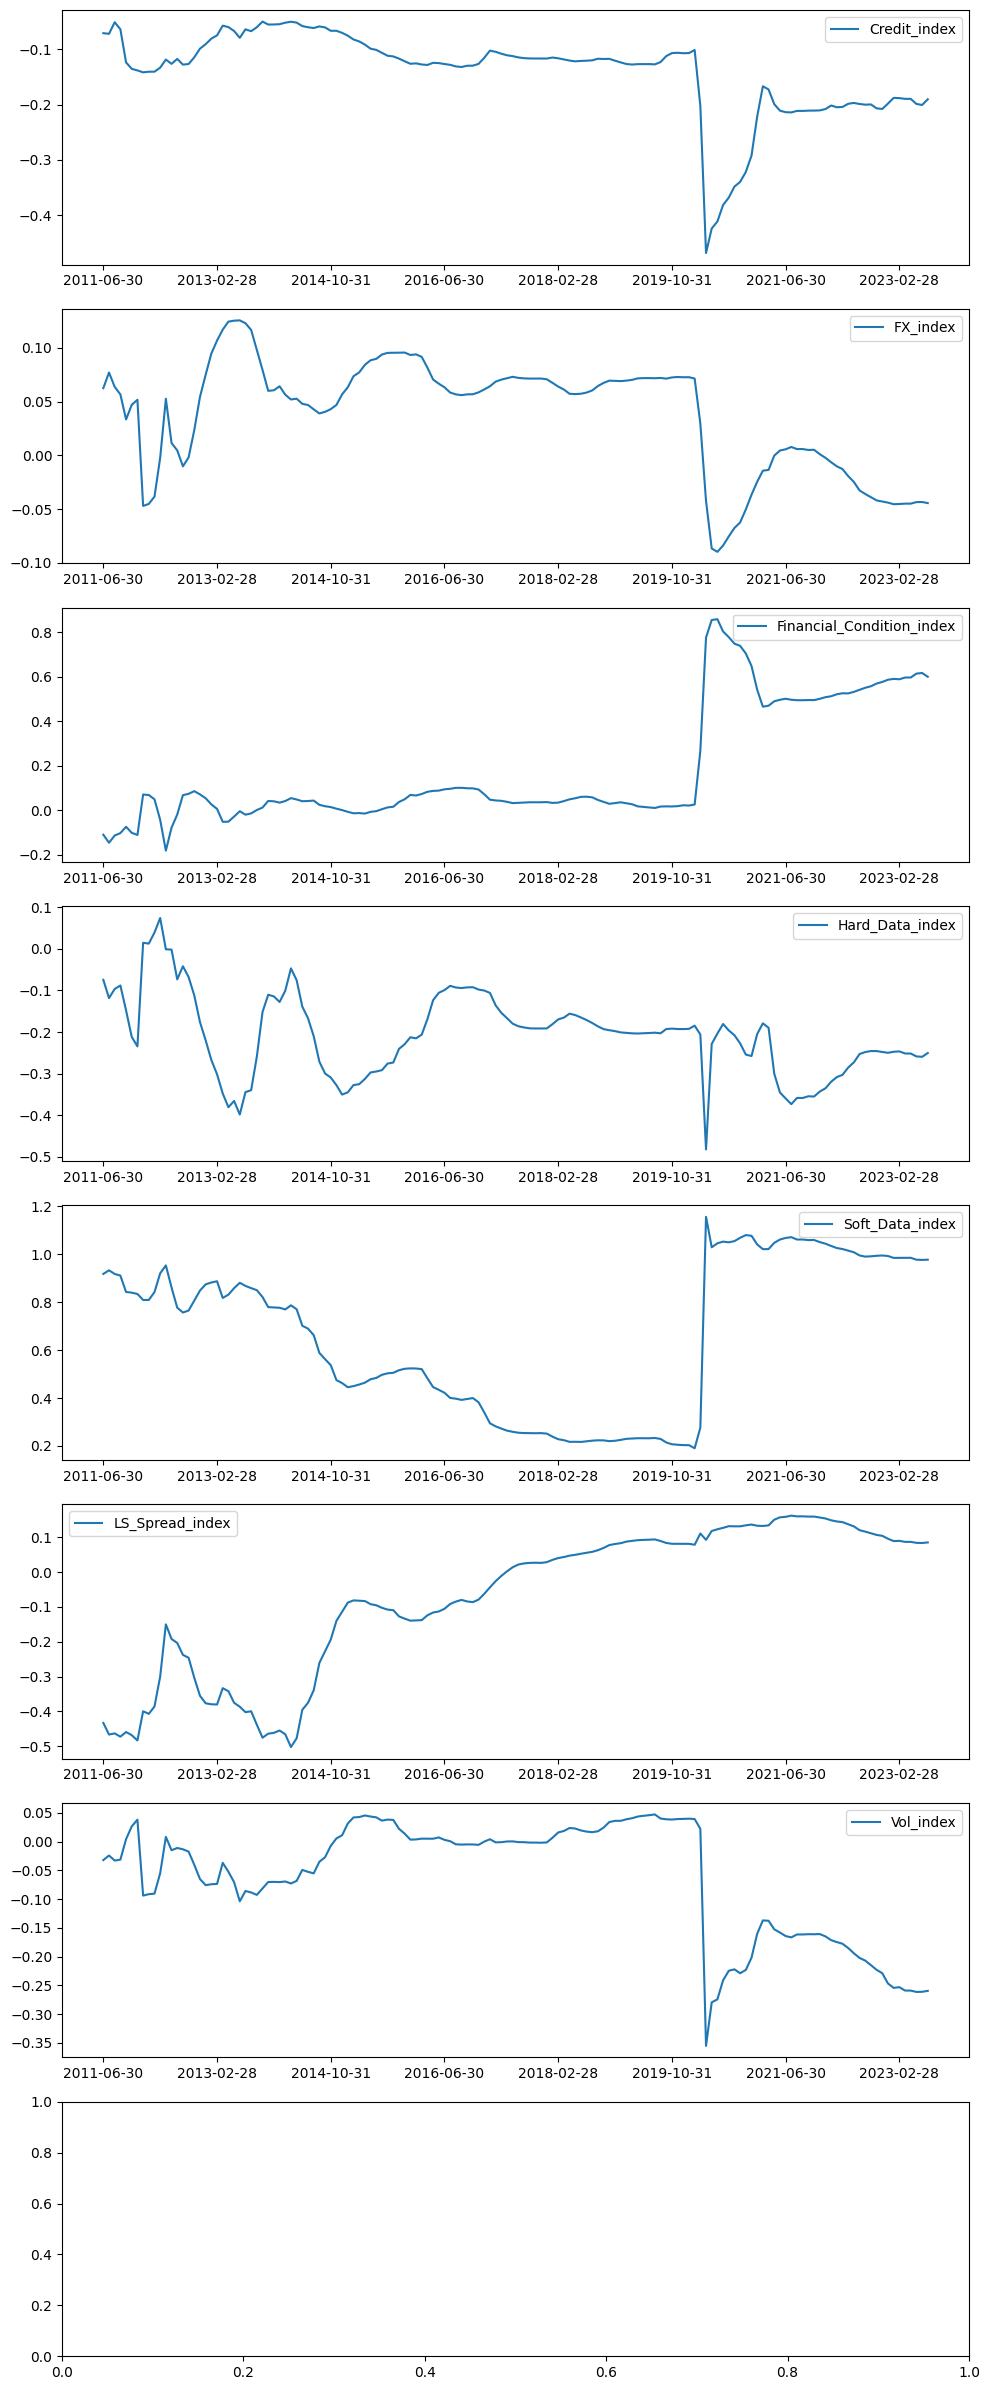

In [ ]:
## coef 값에 대한 Flow##

import matplotlib.pyplot as plt
import numpy as np

# 그래프 크기 조정
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(10, 24))

# 각 컬럼에 대해 그래프 그리기
for i, col in enumerate(coef_df.columns[:-2]):
    axes[i].plot(coef_df[col], label=col)
    axes[i].legend()
    axes[i].set_xticks(ticks= np.arange(0, len(coef_df), 20))

plt.tight_layout()
plt.show()

In [ ]:
#################CLI 예측 프로젝트 완료##########################

In [ ]:
####################레짐 분류하기#################

# CSV 파일 로드
NFCI = pd.read_csv('/content/drive/MyDrive/NFCI.csv')

# 0번째 행 삭제
NFCI = NFCI.iloc[1:]

# 0번째 열을 행 인덱스로 설정
NFCI = NFCI.set_index(NFCI.columns[0])

# 행 인덱스 이름 제거
NFCI.index.name = None

# 1번째 열 이름 변경
NFCI = NFCI.rename(columns={NFCI.columns[0]: 'NFCI'})

# 인덱스를 DatetimeIndex로 변환
NFCI.index = pd.to_datetime(NFCI.index)

# 주말을 포함하고 매일의 데이터로 구성된 새로운 데이터 테이블 생성
daily_index = pd.date_range(start=NFCI.index[0], end=Forecast_CLI.index[-1], freq='D')
NFCI_daily = pd.DataFrame(index=daily_index)

# 기존 데이터를 선형 보간법으로 매일 데이터로 채움
NFCI_daily['NFCI'] = NFCI['NFCI'].resample('D').interpolate(method='linear')

# FFILL
NFCI_daily['NFCI'] = NFCI_daily['NFCI'].fillna(method='ffill')

###################Transfer Index 전처리####################################

# CSV 파일 로드
Transfer = pd.read_csv('/content/drive/MyDrive/Real Transfer.csv')

# NaN이 있는 행 모두 제거
Transfer = Transfer.dropna()

# 0번째 행 삭제
Transfer = Transfer.iloc[1:]

# 0번째 열을 행 인덱스로 설정
Transfer = Transfer.set_index(Transfer.columns[0])

# 행 인덱스 이름 제거
Transfer.index.name = None

# 3번째 열만 유지
Transfer = Transfer.iloc[:, 3:4]

# 0번째 열에서 마지막 데이터값 삭제
Transfer.iloc[-1, 0] = None

# 0번째 열 데이터 한 칸씩 밀기
Transfer.iloc[:, 0] = Transfer.iloc[:, 0].shift(1)

# None이 있는 행 삭제
Transfer = Transfer.dropna()

# 0번째 열 이름 변경
Transfer = Transfer.rename(columns={Transfer.columns[0]: "Transfer Ratio"})

# % 기호 제거하고 숫자만 추출하여 수치형으로 변환
Transfer['Transfer Ratio'] = Transfer['Transfer Ratio'].str.replace('%', '').astype(float)

# 인덱스를 DatetimeIndex로 변환
Transfer.index = pd.to_datetime(Transfer.index)

# 주말을 제외하고 매일의 데이터로 구성된 새로운 데이터 테이블 생성
daily_index = pd.date_range(start=Transfer.index[0], end=Transfer.index[-1], freq='D')
Transfer_daily = pd.DataFrame(index=daily_index)

# 기존 데이터를 선형 보간법으로 매일 데이터로 채움
Transfer_daily['Transfer Ratio'] = Transfer['Transfer Ratio'].resample('D').interpolate(method='linear')

######## OECD CLI 원계열 전처리

# CSV 파일 로드
OECD_CLI = pd.read_csv('/content/drive/MyDrive/OECD_CLI.csv')

# 0번째 행 삭제
OECD_CLI = OECD_CLI.iloc[1:]

# 0번째 열을 행 인덱스로 설정
OECD_CLI = OECD_CLI.set_index(OECD_CLI.columns[0])

# 행 인덱스 이름 제거
OECD_CLI.index.name = None

# 1번째 열 이름 변경
OECD_CLI = OECD_CLI.rename(columns={OECD_CLI.columns[0]: 'OECD_CLI'})

# 데이터 형식을 float64로 변환
OECD_CLI['OECD_CLI'] = OECD_CLI['OECD_CLI'].astype(float)

# 인덱스를 DatetimeIndex로 변환
OECD_CLI.index = pd.to_datetime(OECD_CLI.index)

# 주말을 포함하고 매일의 데이터로 구성된 새로운 데이터 테이블 생성
daily_index = pd.date_range(start=OECD_CLI.index[0], end=OECD_CLI.index[-1], freq='D')
OECD_CLI_daily = pd.DataFrame(index=daily_index)

# 기존 데이터를 선형 보간법으로 매일 데이터로 채움
OECD_CLI_daily['OECD_CLI'] = OECD_CLI['OECD_CLI'].resample('D').interpolate(method='linear')

In [ ]:
################# 유니버스 정리하기#############

# SPX Factor 리턴 값

# CSV 파일 로드
Factor_Return = pd.read_csv('/content/drive/MyDrive/SPX factor.csv')

# 0번째 행 삭제
Factor_Return = Factor_Return.iloc[1:]

# 첫번째 열을 행 인덱스로 설정
Factor_Return = Factor_Return.set_index(Factor_Return.columns[0])

# 행 인덱스 이름 제거
Factor_Return.index.name = None

# 값들을 float64 형태로 변환
Factor_Return = Factor_Return.astype(float)

# 일간 수익률 계산
Return = Factor_Return.pct_change()

# 인덱스를 DatetimeIndex로 변환
Return.index = pd.to_datetime(Return.index)

# 주말을 제외하고 매일의 데이터로 구성된 새로운 데이터 테이블 생성
daily_index = pd.date_range(start=Return.index[0], end=Return.index[-1], freq='D')
Return_daily = pd.DataFrame(index=daily_index)

# Return_daily 테이블에 Return 테이블의 데이터 넣기
for column in Return.columns:
    Return_daily[column] = Return[column].reindex(Return_daily.index, fill_value=0)

# 인덱스를 DatetimeIndex로 변환
Return_daily.index = pd.to_datetime(Return_daily.index)

# SPX 리턴 값

# CSV 파일 로드
SPXFactor_Return = pd.read_csv('/content/drive/MyDrive/SPX.csv')

# 0번째 행 삭제
SPXFactor_Return = SPXFactor_Return.iloc[1:]

# 첫번째 열을 행 인덱스로 설정
SPXFactor_Return = SPXFactor_Return.set_index(SPXFactor_Return.columns[0])

# 행 인덱스 이름 제거
SPXFactor_Return.index.name = None

# 값들을 float64 형태로 변환
SPXFactor_Return = SPXFactor_Return.astype(float)

# 일간 수익률 계산
SPXReturn = SPXFactor_Return.pct_change()

# NaN 값이 있는 행 삭제
SPXReturn = SPXReturn.dropna()

# 인덱스를 DatetimeIndex로 변환
SPXReturn.index = pd.to_datetime(SPXReturn.index)

# 주말을 제외하고 매일의 데이터로 구성된 새로운 데이터 테이블 생성
daily_index = pd.date_range(start=SPXReturn.index[0], end=SPXReturn.index[-1], freq='D')
SPXReturn_daily = pd.DataFrame(index=daily_index)

# Return_daily 테이블에 Return 테이블의 데이터 넣기
for column in SPXReturn.columns:
    SPXReturn_daily[column] = SPXReturn[column].reindex(SPXReturn_daily.index, fill_value=0)

# 인덱스를 DatetimeIndex로 변환
SPXReturn_daily.index = pd.to_datetime(SPXReturn_daily.index)

# Factor와 bm 리턴 테이블 합치기
Return_daily = pd.concat([Return_daily, SPXReturn_daily], axis=1)
Return_daily = Return_daily.dropna()

Return_daily

,S&P 500 Growth Total Return Index,S&P 500 High Beta Total Return Index,S&P 500 Quality U.S. Dollar Gross Total Return Index,S&P 500 QVML Multi-Factor Index (USD) TR,S&P 500 Value Total Return Index,S&P 500 Revenue-Weighted Index (TR),S&P 500 Minimum Volatility Total Return Index,S&P 500 Equal Weighted USD Total Return Index,S&P 500 Buyback Total Return Index,S&P 500 Low Volatility Total Return Index,S&P 500 Momentum U.S. Dollar Gross Total Return Index,S&P 500 Enhanced Value Total Return Index,S&P 500 Pure Growth Total Return Index,S&P 500 Dividend Aristocrats Total Return Index,S&P 500 Pure Value Total Return Index,S&P 500 Low Volatility High Dividend Index,S&P 500 High Dividend Total Return Index,S&P 100 Total Return 4 JAN 1988 Index,S&P 500 Total Return Index
2000-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-03,0.001417,-0.015358,-0.003845,-0.022220,-0.021831,-0.016490,-0.021033,-0.021011,-0.022262,-0.030415,0.010556,-0.022013,-0.003824,-0.030157,-0.021046,-0.028166,-0.028057,-0.005103,-0.009543
2000-01-04,-0.045331,-0.054621,-0.035950,-0.022359,-0.030251,-0.027664,-0.024479,-0.027083,-0.029297,-0.009124,-0.050423,-0.014888,-0.057716,-0.024182,-0.012941,-0.012747,-0.010692,-0.037754,-0.038310
2000-01-05,-0.004516,-0.012497,0.007275,0.015559,0.009372,0.007194,0.002494,0.005044,0.004834,0.016808,-0.001080,0.013562,-0.012728,0.003427,0.020704,0.013131,0.022168,0.003447,0.002010
2000-01-06,-0.011770,-0.000897,0.010596,0.014675,0.015571,0.014296,0.013744,0.011274,0.003644,0.011134,-0.022359,0.008975,-0.014591,0.016898,0.010337,0.014222,0.013707,0.001569,0.001156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-08-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-08-14,0.009102,0.008404,0.009647,0.001000,0.001968,0.000173,0.001730,-0.000138,-0.001868,-0.003120,0.002531,-0.004712,0.003510,-0.001545,-0.003312,-0.005977,-0.009741,0.008079,0.005811
2023-08-15,-0.010051,-0.016512,-0.010729,-0.010703,-0.012983,0.000000,-0.008968,-0.013458,-0.017274,-0.011384,-0.010246,-0.020755,-0.012351,-0.011880,-0.015288,-0.012588,-0.017819,-0.010918,-0.011397


                 CLI  Transfer       FCI Regime
1990-05-30 -2.690364  0.079465  0.982728    -++
1990-05-31  -2.66078  0.057906  1.085532    -++
1990-06-01 -2.681545  0.038420  1.186347    -++
1990-06-02 -2.696698  0.018193  1.248966    -++
1990-06-03 -2.706876 -0.002783  1.309718    --+
...              ...       ...       ...    ...
2023-07-27  2.220366  0.784426  1.574546    +++
2023-07-28  2.210737  0.751660  1.656899    +++
2023-07-29  2.201135  0.715777  1.735911    +++
2023-07-30  2.191443  0.678674  1.817947    +++
2023-07-31  2.181685  0.640287  1.902608    +++

[12116 rows x 4 columns]


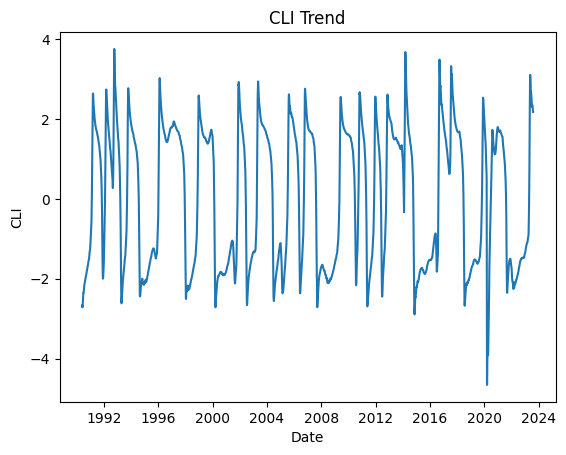

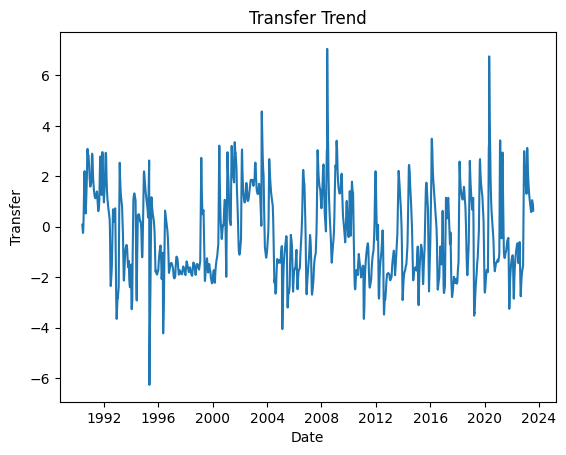

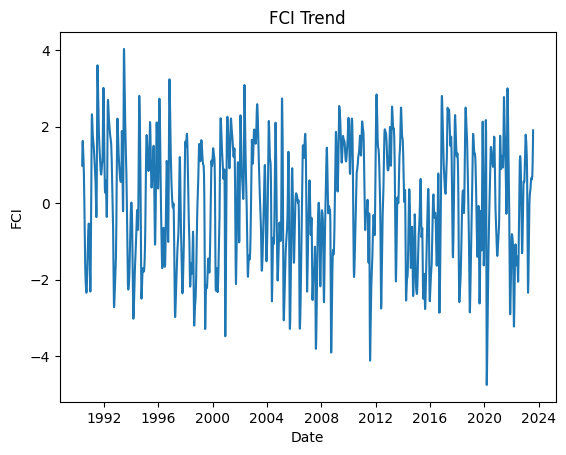

In [ ]:
####### 3개축 레짐 분류

# 데이터프레임 병합을 위한 행 인덱스 생성
index = OECD_CLI_daily.index.intersection(Transfer_daily.index).intersection(NFCI_daily.index)

# 각 데이터프레임을 행 인덱스를 기준으로 병합
merged_data = pd.concat([OECD_CLI_daily.loc[index], Transfer_daily.loc[index], NFCI_daily.loc[index]], axis=1)

# NFCI 열에 -1을 곱하여 데이터 변환
merged_data['NFCI'] = merged_data['NFCI'].mul(-1)

# Rolling Z-Score로 표준화
rolling_z_score = merged_data.rolling(window=120).apply(lambda x: (x[-1] - x.mean()) / x.std())

# 새로운 데이터프레임 Rolling_Z_Index 생성
Rolling_Z_Index = pd.DataFrame(rolling_z_score, columns=merged_data.columns, index=merged_data.index)

# NaN 값이 있는 행 제거
Rolling_Z_Index = Rolling_Z_Index.dropna()

# 열 이름 변경
Rolling_Z_Index.columns = ['CLI', 'Transfer', 'FCI']

#################예측치 대입#################

# 예측치의 롤링 Z-스코어 계산 !!!!!
rolling_z_CLI = Forecast_CLI_daily.rolling(window=120).apply(lambda x: (x[-1] - x.mean()) / x.std(), raw=True)

# 새로운 데이터프레임 Rolling_Z_Forecast 생성
Rolling_Z_Forecast = pd.DataFrame(index=Forecast_CLI_daily.index, columns=Forecast_CLI_daily.columns)

# NaN 값이 없는 행 인덱스 추출
valid_rows = rolling_z_CLI.dropna().index

# Rolling_Z_Index의 값을 Rolling_Z_Forecast에 복사
Rolling_Z_Forecast.loc[valid_rows] = rolling_z_CLI.loc[valid_rows]

# 결측치 제거
Rolling_Z_Forecast = Rolling_Z_Forecast.dropna()

# 마지막달 - 1을 구하기 / 첫번째날 구하기
last_month_index = Rolling_Z_Index.index[-1]
last_month_index = last_month_index - pd.DateOffset(months=1)
firstdate = last_month_index + pd.DateOffset(days=1)

# 이전 데이터 추출
rolling_z_index_subset = Rolling_Z_Index.loc[:last_month_index, Rolling_Z_Index.columns[0]].copy()

# 이후 데이터 추출
rolling_z_forecast_subset = Rolling_Z_Forecast.loc[firstdate:, Rolling_Z_Forecast.columns[0]].copy()

# 신규로 대입
Rolling_Z_Index[Rolling_Z_Index.columns[0]] = pd.concat([rolling_z_index_subset, rolling_z_forecast_subset])

# 국면 분류 함수
def classify_regime(row):
    regime = ""
    if row['CLI'] > 0 and row['Transfer'] > 0 and row['FCI'] > 0:
        regime = "+++"
    elif row['CLI'] > 0 and row['Transfer'] > 0 and row['FCI'] <= 0:
        regime = "++-"
    elif row['CLI'] > 0 and row['Transfer'] <= 0 and row['FCI'] > 0:
        regime = "+-+"
    elif row['CLI'] > 0 and row['Transfer'] <= 0 and row['FCI'] <= 0:
        regime = "+--"
    elif row['CLI'] <= 0 and row['Transfer'] > 0 and row['FCI'] > 0:
        regime = "-++"
    elif row['CLI'] <= 0 and row['Transfer'] > 0 and row['FCI'] <= 0:
        regime = "-+-"
    elif row['CLI'] <= 0 and row['Transfer'] <= 0 and row['FCI'] > 0:
        regime = "--+"
    else:
        regime = "---"
    return regime

# 국면 분류 결과 열 추가
Rolling_Z_Index['Regime'] = Rolling_Z_Index.apply(classify_regime, axis=1)
Regime = Rolling_Z_Index['Regime']

print(Rolling_Z_Index)

# 그래프 그려서 확인하기

import matplotlib.pyplot as plt

# CLI 그래프 그리기
plt.plot(Rolling_Z_Index.index, Rolling_Z_Index['CLI'])
plt.xlabel('Date')
plt.ylabel('CLI')
plt.title('CLI Trend')
plt.show()

# Transfer 그래프 그리기
plt.plot(Rolling_Z_Index.index, Rolling_Z_Index['Transfer'])
plt.xlabel('Date')
plt.ylabel('Transfer')
plt.title('Transfer Trend')
plt.show()

# FCI 그래프 그리기
plt.plot(Rolling_Z_Index.index, Rolling_Z_Index['FCI'])
plt.xlabel('Date')
plt.ylabel('FCI')
plt.title('FCI Trend')
plt.show()

In [ ]:
######다운로드 엑셀로
# 데이터프레임을 CSV 파일로 저장
Rolling_Z_Index.to_csv('Rolling_Z_Index.csv', index=True, encoding='utf-8-sig')

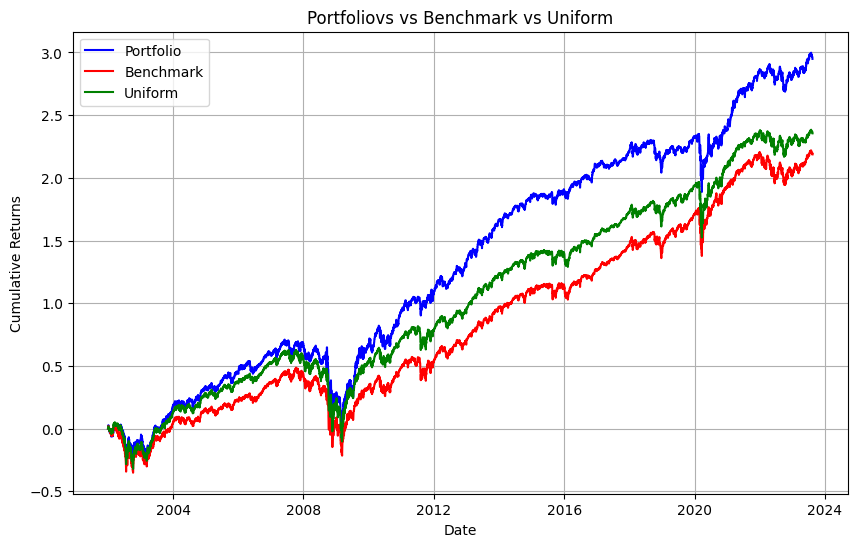

유니버스의 연환산 수익률: 10.15%
포트폴리오의 연환산 수익률: 12.98%
SPX의 연환산 수익률: 9.37%
연율화 포트폴리오의 IR: 1.7
연율화 유니버스의 IR: 0.9


In [ ]:
##### 백테스팅 ##### 월간 제약조건 추가!!

# 레짐 리스트
regime_list = Regime.unique()

# Return_daily와 Regime 데이터프레임을 합치기
merged_data = Return_daily.join(Regime, how='outer')
merged_data = merged_data.loc["2000-01-02":]
merged_data_filled = merged_data.ffill()

# 주말 및 공휴일 제거
merged_data_filtered = merged_data_filled[merged_data_filled.iloc[:, :-1].sum(axis=1) != 0]

# 레짐별로 상위 3개 지수를 추출하여 top_3_series 데이터프레임 생성
top_3_series = pd.DataFrame(index=merged_data_filtered.index, columns=['Index1', 'Index2', 'Index3'])

for i in range(len(merged_data_filtered)):
    if merged_data_filtered.index[i].year >= 2001:
        # 과거를 학습 시작으로 선정
        past_data = merged_data_filtered[(merged_data_filtered.index >= pd.Timestamp(2000, 1, 1)) & (merged_data_filtered.index < merged_data_filtered.index[i])]

# merged_data_filtered.index[i-1008]
# pd.Timestamp(2000, 1, 1)

        # 레짐별로 수익률 평균 계산
        regime_returns = past_data.groupby('Regime').mean()

        # 레짐별 추천 지수 데이터 프레임 생성
        top_3_indices = pd.DataFrame(columns=['Regime', 'Index1', 'Index2', 'Index3'])

        for regime in regime_returns.index:
            regime_data = past_data[past_data['Regime'] == regime].iloc[:, :-1]
            top_3 = regime_data.mean().nlargest(3)
            top_3_indices.loc[len(top_3_indices)] = [regime] + top_3.index.tolist()

        # 추천 지수를 top_3_series에 기록
        current_regime = merged_data_filtered['Regime'].iloc[i]
        if current_regime in top_3_indices['Regime'].values:
            top_3_series.loc[merged_data_filtered.index[i]] = top_3_indices.loc[top_3_indices['Regime'] == current_regime].iloc[:, 1:].values.flatten()
        else:
            top_3_series.loc[merged_data_filtered.index[i]] = ['S&P 500 Total Return Index', 'S&P 500 Total Return Index', 'S&P 500 Total Return Index']

    else:
        # 이전에는 NaN으로 처리
        top_3_series.iloc[i] = [np.nan, np.nan, np.nan]

##########월간 리밸런싱(먼쓸리)

# 이후의 데이터만 추출
top3_2001 = top_3_series.dropna()

# 시리즈를 다시 ffill하기
# 주말 포함한 전체 일간 날짜 범위 생성
start_date = top3_2001.index.min()
end_date = top3_2001.index.max()
full_date_range = pd.date_range(start_date, end_date, freq='D')

# 주말 포함한 전체 일간 날짜를 인덱스로 갖는 새로운 데이터프레임 생성
top3_2001_full_dates = pd.DataFrame(index=full_date_range)

# 기존 top3_2001 데이터를 새로운 데이터프레임에 병합
merged_top3_2001 = top3_2001_full_dates.merge(top3_2001, left_index=True, right_index=True, how='left')

# 빈 공간을 앞쪽 값으로 채우기
merged_top3_2001.ffill(inplace=True)
top3_2001 = merged_top3_2001

# 날짜 인덱스를 Datetime 형식으로 변환
top3_2001.index = pd.to_datetime(top3_2001.index)

# 월말 데이터만 선택하여 새로운 데이터프레임 생성
top3_monthly = top3_2001.groupby(pd.Grouper(freq='M')).last()

# 새로운 데이터프레임 생성
new_table = top3_2001.copy()

# 행 인덱스만 남기고 나머지 열 삭제
new_table = new_table.iloc[:, :0]

# 두 데이터프레임을 merge로 Left Join으로 합치기
merged_table = new_table.merge(top3_monthly, how='left', left_index=True, right_index=True)

# NaN 값 앞쪽으로 채우기
merged_table.ffill(inplace=True)

# 결과 출력
top3_2002 = merged_table.loc['2002-01-01':]

# xx년 이후 Return_daily 데이터프레임 추출
return_daily_since_2002 = Return_daily.loc['2002-01-01':]

# 열 이름 재정의
top3_2002.columns = ['지수1', '지수2', '지수3']

# 빈 데이터프레임 생성
result_df = pd.DataFrame(index=top3_2002.index, columns=['지수1_데일리수익률', '지수2_데일리수익률', '지수3_데일리수익률'])

# top3_2002 데이터프레임 순회
for index, row in top3_2002.iterrows():
    date = index  # 날짜
    index1 = row['지수1']  # 지수1
    index2 = row['지수2']  # 지수2
    index3 = row['지수3']  # 지수3

    # 해당 날짜와 지수에 맞는 데일리 수익률 가져오기
    daily_return1 = return_daily_since_2002.loc[date, index1]
    daily_return2 = return_daily_since_2002.loc[date, index2]
    daily_return3 = return_daily_since_2002.loc[date, index3]

    # 결과 데이터프레임에 값 채우기
    result_df.loc[date, '지수1_데일리수익률'] = daily_return1
    result_df.loc[date, '지수2_데일리수익률'] = daily_return2
    result_df.loc[date, '지수3_데일리수익률'] = daily_return3

# 포트폴리오 가중치
weight1 = 0.6
weight2 = 0.3
weight3 = 0.1

# 빈 데이터프레임 생성
portfolio_returns = pd.DataFrame(index=result_df.index, columns=['포트폴리오_데일리수익률'])

# result_df 순회
for date, row in result_df.iterrows():
    return1 = row['지수1_데일리수익률']
    return2 = row['지수2_데일리수익률']
    return3 = row['지수3_데일리수익률']

    # 포트폴리오 수익률 계산
    portfolio_return = (weight1 * return1) + (weight2 * return2) + (weight3 * return3)

    # 결과 데이터프레임에 값 채우기
    portfolio_returns.loc[date, '포트폴리오_데일리수익률'] = portfolio_return

# 데이터 필터링
portfolio_returns_after_2002 = portfolio_returns
Universe_returns_after_2002 = Return_daily.mean(axis=1)['2002':]
benchmark_returns_after_2002 = SPXReturn_daily.mean(axis=1)['2002':]

# 누적 수익률 계산
portfolio_cum_returns = portfolio_returns_after_2002.cumsum()
Universe_cum_returns = Universe_returns_after_2002.cumsum()
benchmark_cum_returns = benchmark_returns_after_2002.cumsum()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cum_returns, label='Portfolio', color='blue')
plt.plot(benchmark_cum_returns, label='Benchmark', color='red')
plt.plot(Universe_cum_returns, label='Uniform', color='Green')
plt.title("Portfoliovs vs Benchmark vs Uniform")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

################# 월간 리밸런싱 기준으로 연환산 수익률 계산

# UV의 연환산 수익률 계산하기

# 날짜를 연도-월 형식으로 변환하여 월간 그룹화
Return_daily['YearMonth'] = Return_daily.index.to_period('M')
groups = Return_daily.groupby('YearMonth')

# 월간 수익률 계산
Return_monthly = groups.sum()
Return_monthly = Return_monthly.loc['2002':]

# 매달 동일비중으로 구성하는 포트폴리오의 연환산 수익률 계산
uv_return = Return_monthly.mean(axis=1)  # 월간 수익률의 평균을 계산하여 포트폴리오 수익률로 사용
uv_cumulative_return = (uv_return + 1).cumprod() - 1  # 연간 누적 수익률 계산
uv_annualized_return = (1 + uv_cumulative_return[-1]) ** (12 / len(uv_cumulative_return)) - 1  # 연환산 수익률 계산

# 결과 출력
print("유니버스의 연환산 수익률: {:.2%}".format(uv_annualized_return))

# PF의 연환산 수익률 계산하기

# 날짜를 연도-월 형식으로 변환하여 월간 그룹화
portfolio_returns_after_2002['YearMonth'] = portfolio_returns_after_2002.index.to_period('M')
groups_2 = portfolio_returns_after_2002.groupby('YearMonth')

# 월간 수익률 계산
pf_return = groups_2.sum()
pf_cumulative_return = (pf_return + 1).cumprod() - 1  # 연간 누적 수익률 계산
pf_annualized_return = (1 + pf_cumulative_return.iloc[-1, 0]) ** (12 / len(pf_cumulative_return)) - 1  # 연환산 수익률 계산

# 결과 출력
print("포트폴리오의 연환산 수익률: {:.2%}".format(pf_annualized_return))

# SPX의 연환산 수익률 계산하기

# 날짜를 연도-월 형식으로 변환하여 월간 그룹화
SPXReturn_daily['YearMonth'] = SPXReturn_daily.index.to_period('M')
groups_3 = SPXReturn_daily.groupby('YearMonth')

# 월간 수익률 계산
SPXReturn_monthly = groups_3.sum()
SPXReturn_monthly = SPXReturn_monthly.loc['2002':]

# 매달 동일비중으로 구성하는 포트폴리오의 연환산 수익률 계산
BM_return = SPXReturn_monthly.mean(axis=1)  # 월간 수익률의 평균을 계산하여 포트폴리오 수익률로 사용
BM_cumulative_return = (BM_return + 1).cumprod() - 1  # 연간 누적 수익률 계산
BM_annualized_return = (1 + BM_cumulative_return[-1]) ** (12 / len(BM_cumulative_return)) - 1  # 연환산 수익률 계산

# 결과 출력
print("SPX의 연환산 수익률: {:.2%}".format(BM_annualized_return))

# 데이터 프레임 초기화
Return_daily = Return_daily.drop('YearMonth', axis=1) if 'YearMonth' in Return_daily.columns else Return_daily
portfolio_returns_after_2002 = portfolio_returns_after_2002.drop('YearMonth', axis=1) if 'YearMonth' in portfolio_returns_after_2002.columns else portfolio_returns_after_2002
SPXReturn_daily = SPXReturn_daily.drop('YearMonth', axis=1) if 'YearMonth' in SPXReturn_daily.columns else SPXReturn_daily

### TE /IR 계산

# 시리즈를 데이터프레임으로 변환
BM_return_df = pd.DataFrame(BM_return)

# 열 인덱스명 변경
BM_return_df.columns = ['bm']

# 시리즈를 데이터프레임으로 변환
uv_return_df = pd.DataFrame(uv_return)

# 열 인덱스명 변경
uv_return_df.columns = ['uv']

# 세 개의 데이터프레임을 합치기 위해 concat 사용
combined_df = pd.concat([pf_return, uv_return_df, BM_return_df], axis=1)

# 열 이름 변경
combined_df.columns = ['pf', 'uv', 'bm']

# 계산
excess_returns_df = combined_df[['pf', 'uv']].sub(combined_df['bm'], axis=0)
excess_squared = excess_returns_df ** 2
sum_squared = excess_squared.sum()
n = len(excess_returns_df) - 1
tracking_error = (sum_squared / n) ** 0.5

pf_tracking_error = tracking_error['pf']
uv_tracking_error = tracking_error['uv']

pf_ir = (excess_returns_df['pf'].mean() / pf_tracking_error) * 12
uv_ir = (excess_returns_df['uv'].mean() / uv_tracking_error) * 12

print("연율화 포트폴리오의 IR: {:.1f}".format(pf_ir))
print("연율화 유니버스의 IR: {:.1f}".format(uv_ir))

In [ ]:
######다운로드 엑셀로
# 데이터프레임을 CSV 파일로 저장
portfolio_cum_returns.to_csv('portfolio_cum_returns.csv', index=True, encoding='utf-8-sig')
Universe_cum_returns.to_csv('Universe_cum_returns.csv', index=True, encoding='utf-8-sig')
benchmark_cum_returns.to_csv('benchmark_cum_returns.csv', index=True, encoding='utf-8-sig')

In [ ]:
top_3_indices

,Regime,Index1,Index2,Index3
0,+++,S&P 500 Pure Value Total Return Index,S&P 500 High Beta Total Return Index,S&P 500 Enhanced Value Total Return Index
1,++-,S&P 500 High Beta Total Return Index,S&P 500 Pure Growth Total Return Index,S&P 500 Buyback Total Return Index
2,+-+,S&P 500 Pure Growth Total Return Index,S&P 500 High Beta Total Return Index,S&P 500 Momentum U.S. Dollar Gross Total Retur...
3,+--,S&P 500 High Beta Total Return Index,S&P 500 High Dividend Total Return Index,S&P 500 Enhanced Value Total Return Index
4,-++,S&P 500 Buyback Total Return Index,S&P 500 Low Volatility High Dividend Index,S&P 500 Pure Value Total Return Index
5,-+-,S&P 500 Growth Total Return Index,S&P 500 Quality U.S. Dollar Gross Total Return...,S&P 100 Total Return 4 JAN 1988 Index
6,--+,S&P 500 Pure Growth Total Return Index,S&P 500 High Beta Total Return Index,S&P 500 Momentum U.S. Dollar Gross Total Retur...
7,---,S&P 500 Low Volatility High Dividend Index,S&P 500 Low Volatility Total Return Index,S&P 500 Dividend Aristocrats Total Return Index


In [ ]:
regime_returns
regime_returns.to_csv('regime_returns.csv', index=True, encoding='utf-8-sig')

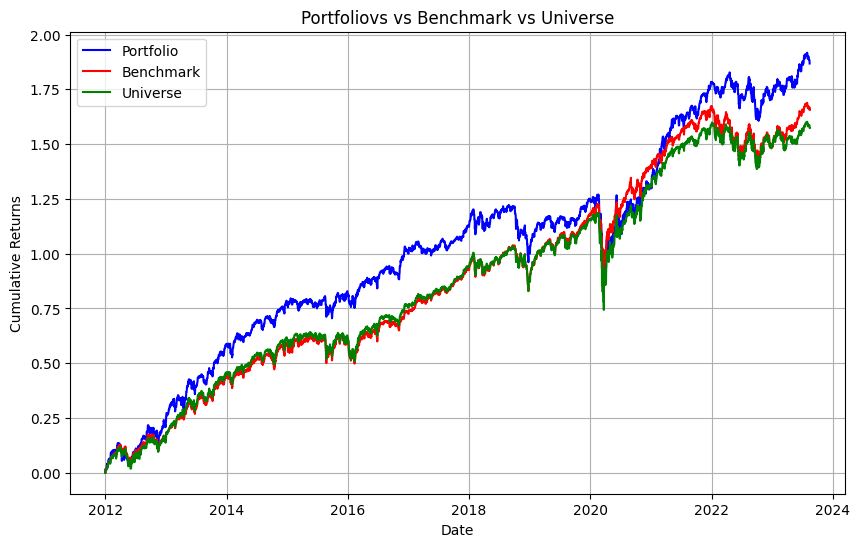

포트폴리오_데일리수익률    1.867989
Name: 2023-08-15 00:00:00, dtype: object
1.6563332761809466


In [ ]:
# 데이터 필터링
portfolio_returns_after_2012 = portfolio_returns.loc["2012-01-01":]
Universe_returns_after_2012 = Return_daily.mean(axis=1)['2012':]
benchmark_returns_after_2012 = SPXReturn_daily.mean(axis=1)['2012':]
portfolio_returns_after_2012 = portfolio_returns_after_2012.drop('YearMonth', axis=1) if 'YearMonth' in portfolio_returns_after_2012.columns else portfolio_returns_after_2012

# 누적 수익률 계산
portfolio_cum_returns_2012 = portfolio_returns_after_2012.cumsum()
Universe_cum_returns_2012 = Universe_returns_after_2012.cumsum()
benchmark_cum_returns_2012 = benchmark_returns_after_2012.cumsum()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cum_returns_2012, label='Portfolio', color='blue')
plt.plot(benchmark_cum_returns_2012, label='Benchmark', color='red')
plt.plot(Universe_cum_returns_2012, label='Universe', color='Green')
plt.title("Portfoliovs vs Benchmark vs Universe")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

# 누적 수익률 텍스트로 표시
last_portfolio_cum_return = portfolio_cum_returns_2012.iloc[-1]
last_benchmark_cum_return = benchmark_cum_returns_2012.iloc[-1]

print(last_portfolio_cum_return)
print(last_benchmark_cum_return)

In [ ]:
######다운로드 엑셀로
# 데이터프레임을 CSV 파일로 저장
portfolio_cum_returns_2012.to_csv('portfolio_cum_returns_12.csv', index=True, encoding='utf-8-sig')
Universe_cum_returns_2012.to_csv('Universe_cum_returns_12.csv', index=True, encoding='utf-8-sig')
benchmark_cum_returns_2012.to_csv('benchmark_cum_returns_12.csv', index=True, encoding='utf-8-sig')

In [ ]:
#########################################################################################################################################

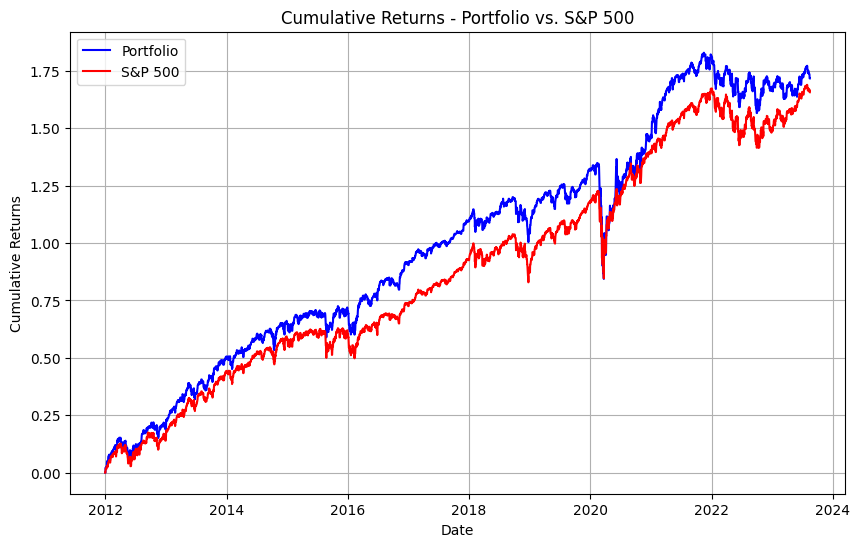

Portfolio Cumulative Returns: 171.65%
S&P 500 Cumulative Returns: 165.63%


In [ ]:
###### ER 코드

import pandas as pd
import matplotlib.pyplot as plt
import datetime

################# 유니버스 정리하기#############

# SPX Factor 값

# CSV 파일 로드
Factor_Return = pd.read_csv('/content/drive/MyDrive/SPX factor.csv')

# 0번째 행 삭제
Factor_Return = Factor_Return.iloc[1:]

# 첫번째 열을 행 인덱스로 설정
Factor_Return = Factor_Return.set_index(Factor_Return.columns[0])

# 행 인덱스 이름 제거
Factor_Return.index.name = None

# 값들을 float64 형태로 변환
Factor_Return = Factor_Return.astype(float)

# NaN 값이 있는 행 삭제
Factor_Return = Factor_Return.dropna()

# 인덱스를 DatetimeIndex로 변환
Factor_Return.index = pd.to_datetime(Factor_Return.index)

# 주말을 제외하고 매일의 데이터로 구성된 새로운 데이터 테이블 생성
daily_index = pd.date_range(start=Factor_Return.index[0], end=Factor_Return.index[-1], freq='D')
Return_daily = pd.DataFrame(index=daily_index)

# Return_daily 테이블에 Return 테이블의 데이터 넣기
for column in Factor_Return.columns:
    Return_daily[column] = Factor_Return[column].reindex(Return_daily.index, fill_value=0)

# 인덱스를 DatetimeIndex로 변환
Return_daily.index = pd.to_datetime(Return_daily.index)

# SPX 값

# CSV 파일 로드
SPXFactor_Return = pd.read_csv('/content/drive/MyDrive/SPX.csv')

# 0번째 행 삭제
SPXFactor_Return = SPXFactor_Return.iloc[1:]

# 첫번째 열을 행 인덱스로 설정
SPXFactor_Return = SPXFactor_Return.set_index(SPXFactor_Return.columns[0])

# 행 인덱스 이름 제거
SPXFactor_Return.index.name = None

# 값들을 float64 형태로 변환
SPXFactor_Return = SPXFactor_Return.astype(float)

# NaN 값이 있는 행 삭제
SPXFactor_Return = SPXFactor_Return.dropna()

# 인덱스를 DatetimeIndex로 변환
SPXFactor_Return.index = pd.to_datetime(SPXFactor_Return.index)

# 주말을 제외하고 매일의 데이터로 구성된 새로운 데이터 테이블 생성
daily_index = pd.date_range(start=SPXFactor_Return.index[0], end=SPXFactor_Return.index[-1], freq='D')
SPXReturn_daily = pd.DataFrame(index=daily_index)

# Return_daily 테이블에 Return 테이블의 데이터 넣기
for column in SPXFactor_Return.columns:
    SPXReturn_daily[column] = SPXFactor_Return[column].reindex(SPXReturn_daily.index, fill_value=0)

# 인덱스를 DatetimeIndex로 변환
SPXReturn_daily.index = pd.to_datetime(SPXReturn_daily.index)

# 테이블 합치기
uv_index = pd.concat([Return_daily, SPXReturn_daily], axis=1)

### EBITDA 12MF 정리

# CSV 파일 로드
EBITDA = pd.read_csv('/content/drive/MyDrive/EBITDA12MF.csv')

# 0번째 행 삭제
EBITDA = EBITDA.iloc[1:]

# 첫번째 열을 행 인덱스로 설정
EBITDA = EBITDA.set_index(EBITDA.columns[0])

# 행 인덱스 이름 제거
EBITDA.index.name = None

# 값들을 float64 형태로 변환
EBITDA = EBITDA.astype(float)

# 인덱스를 DatetimeIndex로 변환
EBITDA.index = pd.to_datetime(EBITDA.index)

# 주말을 제외하고 매일의 데이터로 구성된 새로운 데이터 테이블 생성
daily_index = pd.date_range(start=EBITDA.index[0], end=EBITDA.index[-1], freq='D')
EBITDA_daily = pd.DataFrame(index=daily_index)

# Return_daily 테이블에 Return 테이블의 데이터 넣기
for column in EBITDA.columns:
    EBITDA_daily[column] = EBITDA[column].reindex(EBITDA_daily.index, fill_value=0)

# 인덱스를 DatetimeIndex로 변환
EBITDA_daily.index = pd.to_datetime(EBITDA_daily.index)

# 2006-12-01 이후의 데이터만 필터링
EBITDA_filtered = EBITDA_daily[EBITDA_daily.index >= '2006-12-01']

# 월말 데이터 추려내기
EBITDA_monthly = EBITDA_filtered.resample('M').last()

# 전월 대비 변화율 계산
EBITDA_monthly_chg = EBITDA_monthly.pct_change()

# 첫번째 월의 NaN 값 삭제
EBITDA_monthly_chg = EBITDA_monthly_chg.drop(EBITDA_monthly_chg.index[0])

# 마지막 행 삭제
EBITDA_monthly_chg = EBITDA_monthly_chg[:-1]

# 비중을 나타내는 데이터프레임 생성
weights = pd.DataFrame(0, index=EBITDA_monthly_chg.index, columns=EBITDA_monthly_chg.columns)

# 가장 값이 큰 3개의 인덱스에 비중 부여
for idx, row in EBITDA_monthly_chg.iterrows():
    top_3_indices = row.nlargest(3).index
    weights.loc[idx, top_3_indices[0]] = 0.6
    weights.loc[idx, top_3_indices[1]] = 0.3
    weights.loc[idx, top_3_indices[2]] = 0.1

# weights와 일치하는 열만 발라내기
matching_columns = weights.columns.intersection(uv_index.columns)
uv_filtered = uv_index[matching_columns]

# 2007-01-01 이후 데이터만 필터링
uv_filtered = uv_filtered.loc['2007-01-31':]

# 보간하여 포트폴리오 데이터프레임 생성
portfolio = pd.DataFrame(index=uv_filtered.index, columns=uv_filtered.columns)

for column in portfolio.columns:
    portfolio[column] = uv_filtered[column].interpolate(method='time')

portfolio = portfolio.fillna(method='ffill')

# 월별 비중 데이터프레임 재인덱싱
weights_monthly = weights.resample('M').last()
weights_monthly = weights_monthly.reindex(portfolio.index, method='ffill')

# 수익률 계산
portfolio_returns = (portfolio.pct_change() * weights_monthly.shift()).sum(axis=1)
portfolio_returns = portfolio_returns.drop(portfolio_returns.index[0])
portfolio_returns = portfolio_returns.loc[datetime.datetime(2012, 1, 1):]

# 누적 수익률 계산
ER_cumulative_returns = portfolio_returns.cumsum()

# S&P 500 Total Return Index의 일별 수익률 계산
benchmark_returns = uv_filtered['S&P 500 Total Return Index'].pct_change()
benchmark_returns = benchmark_returns.drop(benchmark_returns.index[0])
benchmark_returns = benchmark_returns.loc[datetime.datetime(2012, 1, 1):]

# S&P 500 Total Return Index의 누적 수익률 계산
benchmark_cumulative_returns = benchmark_returns.cumsum()

# 어닝 리비전의 누적 수익률과 S&P 500 Total Return Index의 누적 수익률 그래프로 비교
plt.figure(figsize=(10, 6))
plt.plot(ER_cumulative_returns.index, ER_cumulative_returns, color='blue', label='Portfolio')
plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, color='red', label='S&P 500')
plt.title('Cumulative Returns - Portfolio vs. S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# 누적 수익률
portfolio_cumulative_returns = ER_cumulative_returns[-1]
benchmark_cumulative_returns = benchmark_cumulative_returns[-1]

# 누적 수익률 텍스트로 표시
print("Portfolio Cumulative Returns: {:.2%}".format(portfolio_cumulative_returns))
print("S&P 500 Cumulative Returns: {:.2%}".format(benchmark_cumulative_returns))

ER_st_returns = portfolio_returns.to_frame(name='ER_st')


In [ ]:
# 데일리 수익률 계산
daily_returns = uv_filtered.pct_change()

# 데일리 수익률의 행 평균 계산
uniform_return = daily_returns.mean(axis=1).to_frame(name='uniform_return')

# 2012년 1월 1일 이후 데이터만 필터링
uniform_return_filtered = uniform_return.loc[datetime.datetime(2012, 1, 1):]

# 누적 수익률 계산
uniform_return_cumsum = uniform_return_filtered.cumsum()

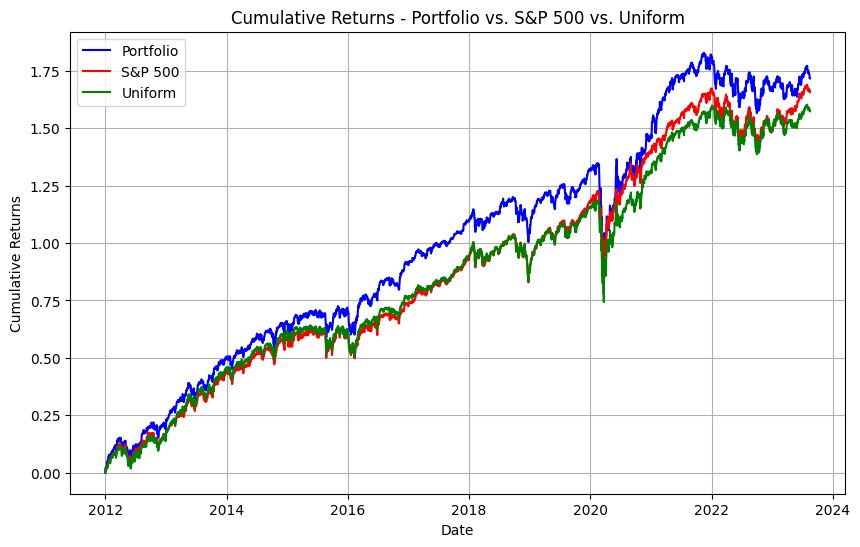

Portfolio Cumulative Returns: 171.65%
S&P 500 Cumulative Returns: 165.63%
Uniform Cumulative Returns: 157.35%


In [ ]:
# S&P 500 Total Return Index의 일별 수익률 계산
benchmark_returns = uv_filtered['S&P 500 Total Return Index'].pct_change()
benchmark_returns = benchmark_returns.drop(benchmark_returns.index[0])
benchmark_returns = benchmark_returns.loc[datetime.datetime(2012, 1, 1):]

# S&P 500 Total Return Index의 누적 수익률 계산
benchmark_cumulative_returns = benchmark_returns.cumsum()

# 어닝 리비전의 누적 수익률과 S&P 500 Total Return Index의 누적 수익률 그래프로 비교
plt.figure(figsize=(10, 6))
plt.plot(ER_cumulative_returns.index, ER_cumulative_returns, color='blue', label='Portfolio')
plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, color='red', label='S&P 500')
plt.plot(uniform_return_cumsum.index, uniform_return_cumsum, color='green', label='Uniform')
plt.title('Cumulative Returns - Portfolio vs. S&P 500 vs. Uniform')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# 누적 수익률
portfolio_cumulative_returns = ER_cumulative_returns[-1]
benchmark_cumulative_returns = benchmark_cumulative_returns[-1]
uniform_cumulative_returns = uniform_return_cumsum.iloc[-1]

# 누적 수익률 텍스트로 표시
print("Portfolio Cumulative Returns: {:.2%}".format(portfolio_cumulative_returns))
print("S&P 500 Cumulative Returns: {:.2%}".format(benchmark_cumulative_returns))
print("Uniform Cumulative Returns: {:.2%}".format(float(uniform_cumulative_returns)))

In [ ]:
######다운로드 엑셀로
# 데이터프레임을 CSV 파일로 저장
ER_cumulative_returns.to_csv('ER_cum_returns_12.csv', index=True, encoding='utf-8-sig')

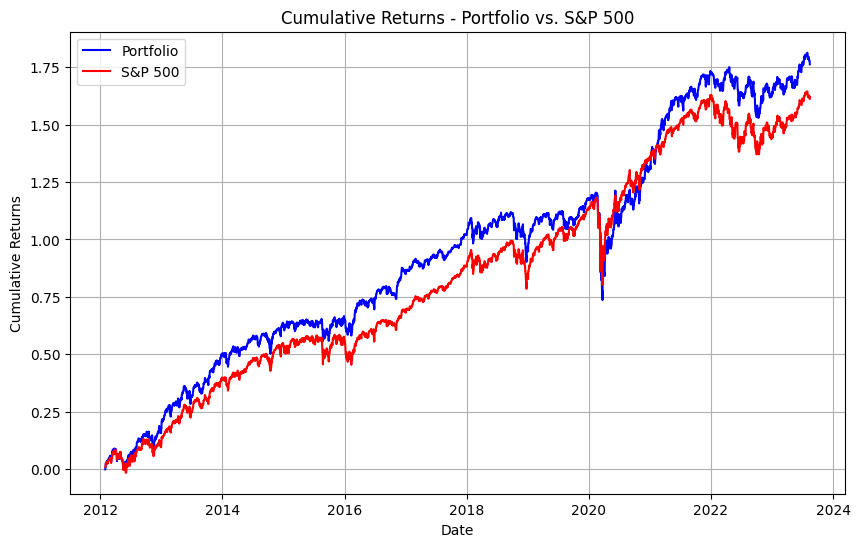

PF_return    1.762433
Name: 2023-08-15 00:00:00, dtype: float64


In [ ]:
# 데이터프레임으로 변환
benchmark_returns_df = pd.DataFrame({'수익률': benchmark_returns_after_2012})
benchmark_returns_df.index.name = '날짜'

# 결과 확인
benchmark_returns_df

# 데이터프레임 합치기
combined_df = pd.concat([ER_st_returns, portfolio_returns_after_2012, benchmark_returns_df], axis=1)

# float으로 형식 변환
combined_df = combined_df.astype(float)

# 결과 확인
combined_df = combined_df.dropna()
combined_df= combined_df.loc['2012-01-01':]
combined_df.columns = ['ER', 'RG', 'BM']
combined_df

# 월별 수익률 합으로 데이터 테이블 생성
mixed_st_monthly = combined_df.resample('M').sum()

# weight_st 데이터 프레임 생성
weight_st = pd.DataFrame(index=mixed_st_monthly.index, columns=['ER', 'RG'])

# 전략별 수익률 비교 및 weight_st 값 할당
for date, row in mixed_st_monthly.iterrows():
    if mixed_st_monthly.loc[date, 'ER'] >= mixed_st_monthly.loc[date, 'RG']:
        weight_st.loc[date, 'ER'] = 0.8
        weight_st.loc[date, 'RG'] = 0.2
    else:
        weight_st.loc[date, 'ER'] = 0.2
        weight_st.loc[date, 'RG'] = 0.8
weight_st.index = pd.to_datetime(weight_st.index)

# weight_st의 인덱스를 일간으로 변경하고 앞쪽으로 채워주기
weight_st_daily = weight_st.resample('D').ffill()
weight_st_daily.index = pd.to_datetime(weight_st_daily.index)
combined_df.index = pd.to_datetime(combined_df.index)
merged_df = pd.merge(combined_df, weight_st_daily, left_index=True, right_index=True, how='inner')
merged_df = merged_df.astype(float)
merged_df = merged_df.dropna()

# 리턴과 weight_st_daily를 곱해 최종 포트폴리오 계산
pf_return = pd.DataFrame({'PF_return': merged_df.iloc[:, 0] * merged_df.iloc[:, 3] + merged_df.iloc[:, 1] * merged_df.iloc[:, 4]})

# 최종 포트폴리오 수익률을 누적하여 출력
last_cumulative_return = pf_return.cumsum()

# S&P 500 Total Return Index의 일별 수익률 계산
benchmark_returns = uv_filtered['S&P 500 Total Return Index'].pct_change()
benchmark_returns = benchmark_returns.loc[last_cumulative_return.index]
benchmark_returns = benchmark_returns.drop(benchmark_returns.index[0])

# S&P 500 Total Return Index의 누적 수익률 계산
benchmark_cumulative_returns = benchmark_returns.cumsum()

# 포트폴리오의 누적 수익률과 S&P 500 Total Return Index의 누적 수익률 그래프로 비교
plt.figure(figsize=(10, 6))
plt.plot(last_cumulative_return.index, last_cumulative_return, color='blue', label='Portfolio')
plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, color='red', label='S&P 500')
plt.title('Cumulative Returns - Portfolio vs. S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

last = last_cumulative_return.iloc[-1]

print(last)

In [ ]:
######다운로드 엑셀로
# 데이터프레임을 CSV 파일로 저장
last_cumulative_return.to_csv('last_cumulative_return.csv', index=True, encoding='utf-8-sig')

In [ ]:
#####################################################################################################################

In [ ]:
# 폰트설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 37s (259 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122542 files and dir

In [ ]:
# 폰트로드

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')